In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast

In [43]:
sns.set(rc={'figure.figsize':(15,8)})

In [558]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('noRisk_corr90_CloseEnd.csv')
df['date'] = pd.to_datetime(df.date)

df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [559]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')
df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [560]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [561]:
df.loc[(df.duplicated(subset=['date', 'sorted_pair'], keep=False))].sort_values(by=['date', 'sorted_pair'])

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,open_price_scnd_stock,open_date,close_limit,stop_limit,halflife,days_open,data_ini,data_fin,setor,sorted_pair


In [562]:
def result_calculator(row, kind='CN'):
    
    if kind=='CN':
        multiplier = 1
    if kind == 'BN':
        multiplier = row.beta_open
    
    
    if row['residual_open'] < row['std_open_residual']:
        long_result = np.log(row['price_fst_stock'] / row['open_price_first_stock'])
        short_result = np.log(row['open_price_scnd_stock'] / row['price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = long_result + short_result
    
    elif row['residual_open'] > row['std_open_residual']:
        long_result = np.log(row['open_price_first_stock'] / row['price_fst_stock'])
        short_result = np.log(row['price_scnd_stock'] / row['open_price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = long_result + short_result

    return result 

In [563]:
cond = (df.status.isin(['True', 'close']))

In [564]:
df.loc[cond, 'result'] = df.loc[cond].apply(lambda row: result_calculator(row), axis=1)
df.loc[cond, 'result_beta_neutral'] = df.loc[cond].apply(lambda row: result_calculator(row, kind='BN'), axis=1)


In [613]:
closed_daily.loc['2022-06-30']

result                -0.171935
result_beta_neutral   -0.237635
Name: 2022-06-30 00:00:00, dtype: float64

In [614]:
df.loc[(df.status=='close') & (df.date == '2022-06-30'), ['open_date', 'days_open', 'result']].mean()

<ipython-input-614-126641abf49e>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.loc[(df.status=='close') & (df.date == '2022-06-30'), ['open_date', 'days_open', 'result']].mean()


days_open    57.600000
result       -0.171935
dtype: float64

In [567]:
df.loc[df.status=='']

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,close_limit,stop_limit,halflife,days_open,data_ini,data_fin,setor,sorted_pair,result,result_beta_neutral


In [568]:
df.date.max()

Timestamp('2022-06-30 00:00:00')

In [571]:
closed = df.loc[df.status=='close'].copy()

closed['is_profit'] = closed['result'] > 0
# closed['is_profit_CN'] = closed['result_cash_neutral'] > 0
closed['is_profit_BN'] = closed['result_beta_neutral'] > 0


In [639]:
result = closed[['result', 'result_beta_neutral']].mean()
accuracy = closed[['is_profit','is_profit_BN']].mean()
days_open = closed.days_open.mean()

In [640]:
result_table = {'result': result.values,
                'accuracy': accuracy.values,
                'days open': days_open
               }
pd.DataFrame(result_table, index=['normal', 'beta_neutral'])

,result,accuracy,days open
normal,0.010379,0.696429,32.171429
beta_neutral,0.022461,0.653571,32.171429


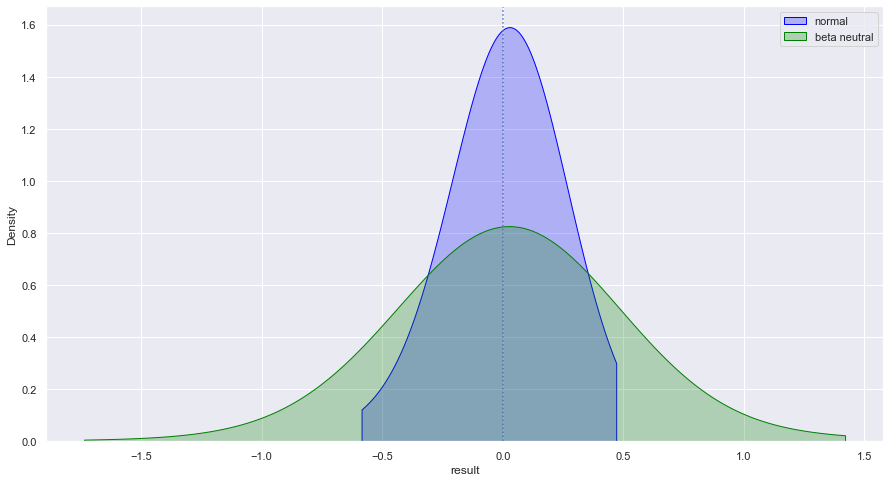

In [641]:
sns.kdeplot(x=closed.result, color='blue', label='normal', bw_adjust=5, cut=0, fill=True)
# sns.kdeplot(x=closed.result_cash_neutral, color='red', label='cash neutral', bw_adjust=5, cut=0, fill=True)
sns.kdeplot(x=closed.result_beta_neutral, color='green', label='beta neutral', bw_adjust=5, cut=0, fill=True)

plt.axvline(x=0, linestyle='dotted')
plt.legend()
plt.show()

In [643]:
# Close by residual
closed_by_residual = closed.loc[abs(df.last_residual) < df.close_limit,['result', 'result_beta_neutral', 'is_profit','is_profit_BN']].agg(['mean', 'count']).T
closed_by_residual

,mean,count
result,0.054848,195.0
result_beta_neutral,0.086737,195.0
is_profit,0.871795,195.0
is_profit_BN,0.830769,195.0


In [576]:
# stop by stop
closed_by_stop = closed.loc[abs(df.last_residual) > df.stop_limit,['result', 'result_beta_neutral', 'is_profit','is_profit_BN']].agg([sum, 'count']).T
closed_by_stop

,sum,count
result,0.0,0.0
result_beta_neutral,0.0,0.0
is_profit,0.0,0.0
is_profit_BN,0.0,0.0


In [577]:
# stop by halflife
closed_by_halflife = closed.loc[closed.days_open > closed.halflife, ['result', 'result_beta_neutral', 'is_profit','is_profit_BN']].agg([sum, 'count']).T
closed_by_halflife

,sum,count
result,0.0,0.0
result_beta_neutral,0.0,0.0
is_profit,0.0,0.0
is_profit_BN,0.0,0.0


In [578]:
closed

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,halflife,days_open,data_ini,data_fin,setor,sorted_pair,result,result_beta_neutral,is_profit,is_profit_BN
7,2019-07-15,"(AZUL4, GOLL4)",close,49.36,38.30,0.985577,0.958189,0.194602,1.308762,1.262734,...,5000.0,7,2019-07-01,2019-12-31,Aéreas,"(AZUL4, GOLL4)",0.037374,0.038440,True,True
106,2019-12-27,"(AZUL4, GOLL4)",close,57.80,36.92,0.947513,1.221358,6.151639,2.780245,1.258947,...,5000.0,98,2019-07-01,2019-12-31,Aéreas,"(AZUL4, GOLL4)",-0.155521,-0.151790,False,False
190,2019-08-30,"(BRFS3, JBSS3)",close,38.14,25.71,0.912186,0.999857,0.779814,1.633379,1.596046,...,11000.0,15,2019-07-01,2019-12-31,Alimentos e Bebidas,"(BRFS3, JBSS3)",0.078559,0.071707,True,True
214,2019-11-22,"(CCRO3, RAIL3)",close,16.79,24.16,0.729863,0.747719,0.226744,0.738815,0.688756,...,7000.0,23,2019-07-01,2019-12-31,Bens Industriais,"(CCRO3, RAIL3)",0.073761,0.059881,True,True
258,2019-12-27,"(RAIL3, WEGE3)",close,26.84,17.10,2.012557,1.107561,-1.211327,1.166806,0.966243,...,10000.0,43,2019-07-01,2019-12-31,Bens Industriais,"(RAIL3, WEGE3)",-0.158446,-0.476541,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12473,2022-06-09,"(LREN3, VIIA3)",close,25.07,2.91,1.333153,1.305167,0.606552,1.530042,1.570381,...,10000.0,4,2019-07-01,2019-12-31,Varejo,"(LREN3, VIIA3)",0.038367,0.014087,True,True
12511,2022-06-30,"(PETZ3, ALPA4)",close,9.93,19.14,0.286549,0.323871,-3.477779,1.865421,1.575374,...,9000.0,37,2022-01-01,2022-07-01,Varejo,"(ALPA4, PETZ3)",-0.081810,-0.145936,False,False
12531,2022-05-03,"(VIIA3, CVCB3)",close,2.86,12.47,0.773178,0.783732,-0.589983,1.390562,1.518323,...,13000.0,19,2019-07-01,2019-12-31,Varejo,"(CVCB3, VIIA3)",-0.085623,-0.156579,False,False
12573,2022-04-26,"(VIIA3, LREN3)",close,3.04,24.31,0.645305,0.657941,-0.416682,1.170359,1.150397,...,8000.0,14,2019-07-01,2019-12-31,Varejo,"(LREN3, VIIA3)",-0.153788,-0.218919,False,False


In [579]:
# closed = closed.loc[closed.halflife.between(0,21)]

In [580]:
halfyear_accuracy

,date,variable,accuracy
0,2019-07-31,normal,1.000000
1,2020-01-31,normal,0.840000
2,2020-07-31,normal,0.843373
3,2021-01-31,normal,0.918919
4,2021-07-31,normal,0.866667
5,2022-01-31,normal,0.904762
6,2022-07-31,normal,0.755102
7,2019-07-31,beta neutral,1.000000
8,2020-01-31,beta neutral,0.820000
9,2020-07-31,beta neutral,0.783133


In [581]:
closed.set_index('date').resample('6M')[['is_profit', 'is_profit_BN']].count()

,is_profit,is_profit_BN
date,,
2019-07-31,4,4
2020-01-31,60,60
2020-07-31,68,68
2021-01-31,54,54
2021-07-31,37,37
2022-01-31,14,14
2022-07-31,43,43


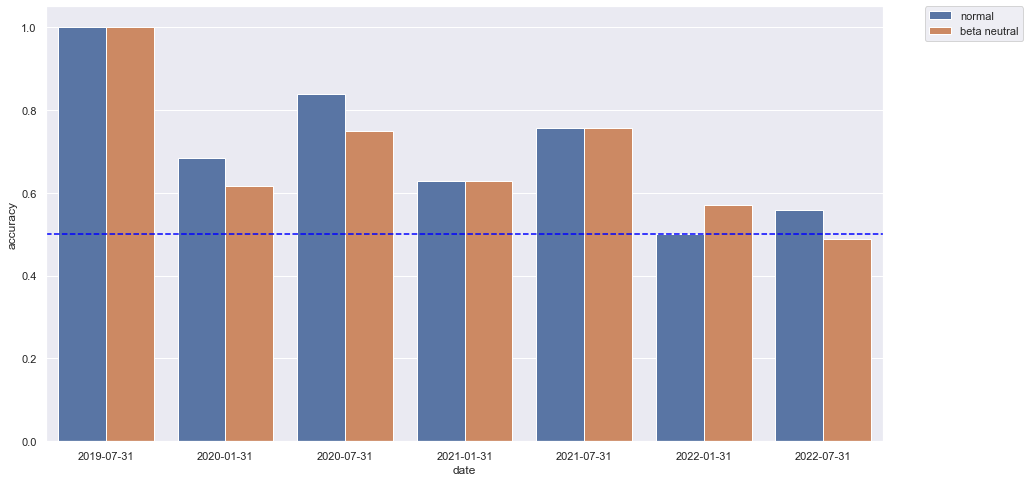

In [644]:
# Halfyear accuracy
halfyear_accuracy = closed.set_index('date').resample('6M')[['is_profit', 'is_profit_BN']].mean().reset_index()
halfyear_accuracy.columns = ['date', 'normal', 'beta neutral']
halfyear_accuracy['date'] = halfyear_accuracy['date'].dt.date
halfyear_accuracy = halfyear_accuracy.melt(id_vars='date', value_name='accuracy')

sns.barplot(x='date', y='accuracy', hue='variable', data=halfyear_accuracy)
plt.axhline(y=0.5, color='blue', linestyle='--')
# plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

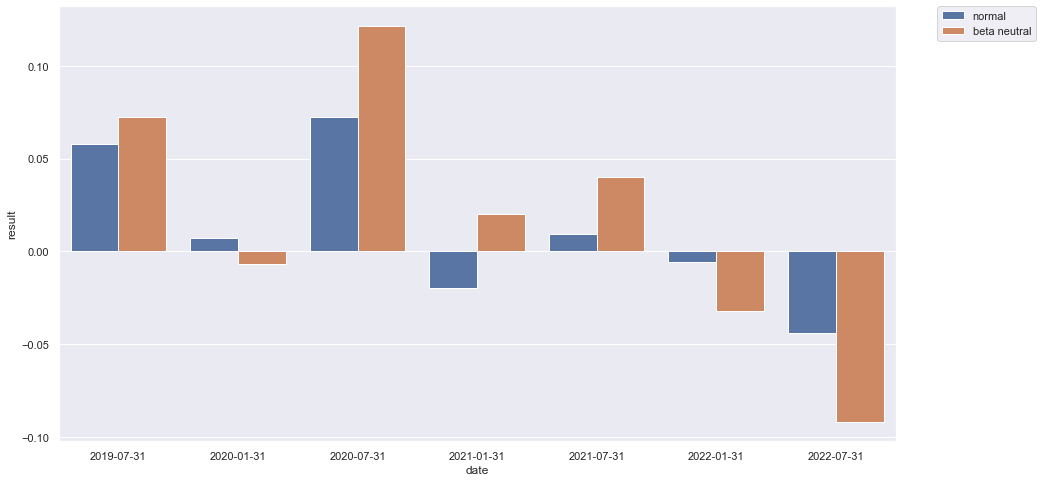

In [647]:
# Halfyear results
halfyear_results = closed.set_index('date').resample('6M')[['result', 'result_beta_neutral']].mean().reset_index()
halfyear_results.columns = ['date', 'normal', 'beta neutral']
halfyear_results['date'] = halfyear_results.date.dt.date
halfyear_results = halfyear_results.melt(id_vars='date', value_name='result')

sns.barplot(x='date', y='result', hue='variable', data=halfyear_results)
# plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [648]:
closed_daily = closed.groupby('date').agg({'result':'mean', 'result_beta_neutral':'mean'})

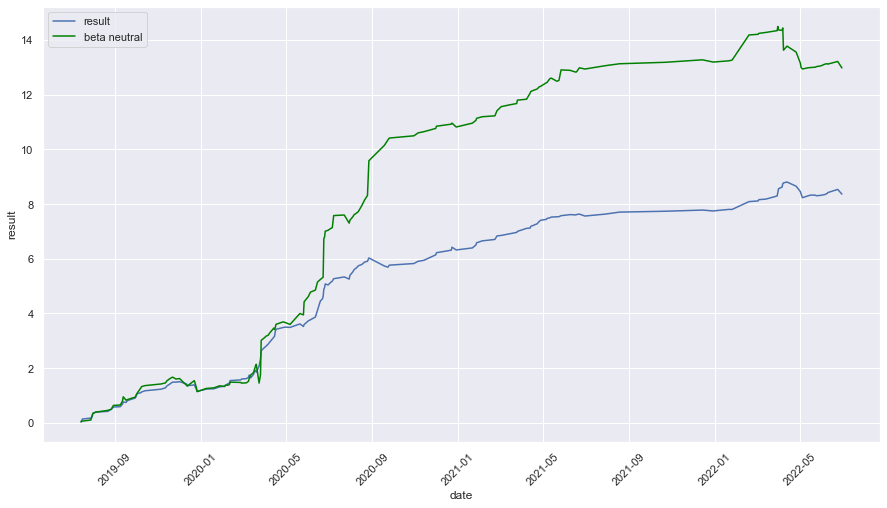

In [649]:
sns.lineplot(x=closed_daily.index, y=closed_daily.result.cumsum(), label='result')
# sns.lineplot(x=closed_daily.index, y=closed_daily.result_cash_neutral.cumsum(),color='red', label='cash neutral')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_beta_neutral.cumsum(),color='green', label='beta neutral')


plt.xticks(rotation=45)
plt.show()

[]

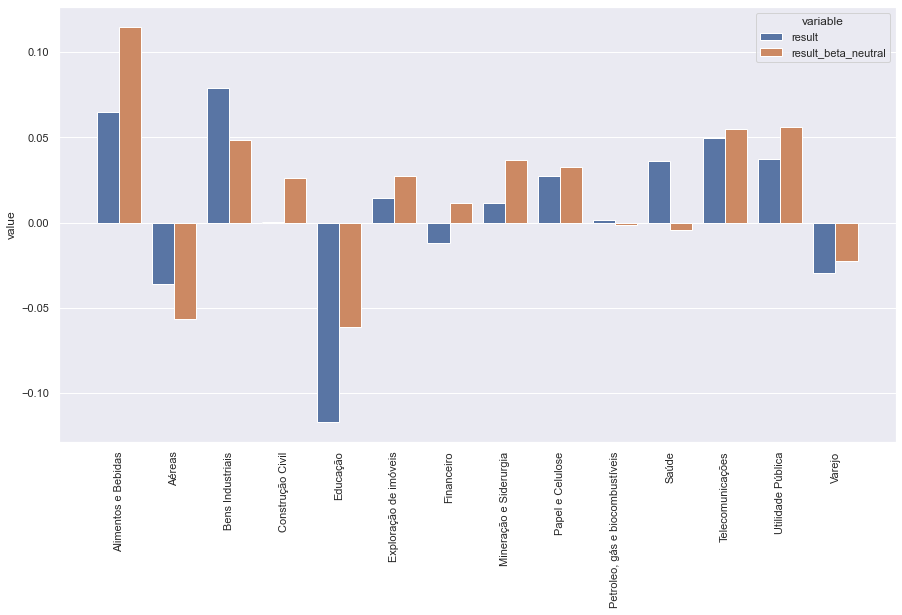

In [651]:
closed_setor = closed[['setor', 'result', 'result_beta_neutral']].melt(id_vars='setor')
closed_setor = closed_setor.groupby(['setor', 'variable'], as_index=False).mean()

plt.figure(figsize=(15,8))

sns.barplot(x='setor', y='value', hue='variable', data=closed_setor, orient='v')
# plt.grid(axis='x')
plt.xticks(rotation=90)
plt.xlabel(None)
plt.plot()

In [593]:
closed_setor.pivot(index='setor', columns='variable', values='value')

variable,result,result_beta_neutral
setor,,
Alimentos e Bebidas,0.323798,0.574727
Aéreas,-0.108428,-0.169141
Bens Industriais,0.634099,0.386803
Construção Civil,0.001210,0.078479
Educação,-0.234223,-0.122463
Exploração de imóveis,0.102905,0.191336
Financeiro,-1.093231,1.065000
Mineração e Siderurgia,0.330549,1.021636
Papel e Celulose,0.137403,0.163326


[]

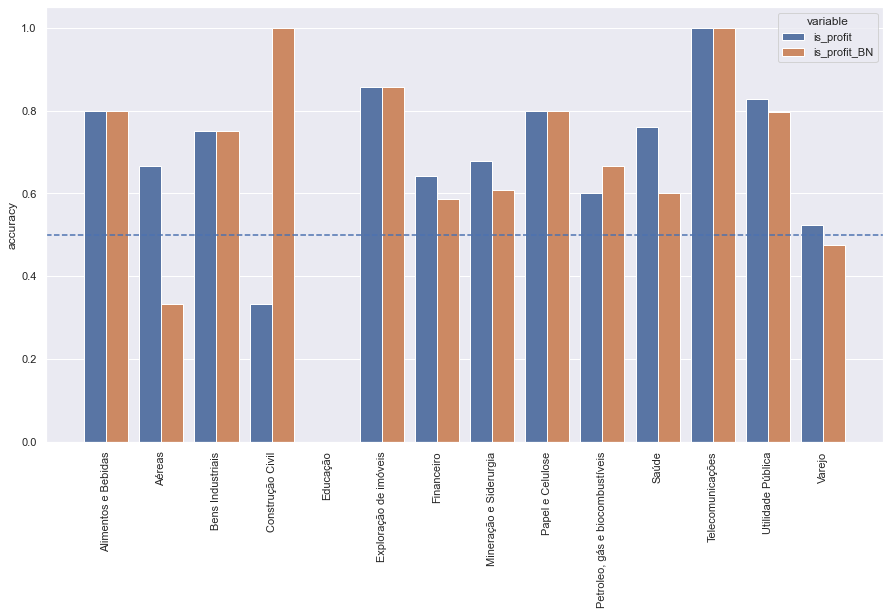

In [652]:
closed_setor_accuracy = closed[['setor', 'is_profit', 'is_profit_BN']].melt(id_vars='setor', value_name='accuracy')
closed_setor_accuracy = closed_setor_accuracy.groupby(['setor', 'variable'], as_index=False).mean()
sns.barplot(x='setor', y='accuracy', hue='variable', data=closed_setor_accuracy, orient='v', )
plt.axhline(y=0.5, linestyle='--')
plt.xlabel(None)
plt.xticks(rotation=90)
# plt.grid(axis='x')
plt.plot()

In [596]:
closed_setor_accuracy.pivot(index='setor', columns='variable', values='accuracy')

variable,is_profit,is_profit_BN
setor,,
Alimentos e Bebidas,0.800000,0.800000
Aéreas,0.666667,0.333333
Bens Industriais,0.750000,0.750000
Construção Civil,0.333333,1.000000
Educação,0.000000,0.000000
Exploração de imóveis,0.857143,0.857143
Financeiro,0.641304,0.586957
Mineração e Siderurgia,0.678571,0.607143
Papel e Celulose,0.800000,0.800000


In [597]:
pair_closed = closed.groupby('sorted_pair').agg(
    result_sum=('result', 'mean'),
    result_mean=('result', 'mean'),
    count=('result', 'count'),
    accuracy=('is_profit', 'mean'),
    sector=('setor', 'last')
    )

pair_closed.loc[pair_closed['count']>3].sort_values(by=['accuracy', 'count'], ascending=False).tail(25)

,result_sum,result_mean,count,accuracy,sector
sorted_pair,,,,,
"(SBSP3, TAEE11)",0.045077,0.045077,7,1.000000,Utilidade Pública
"(EQTL3, TAEE11)",0.086219,0.086219,6,1.000000,Utilidade Pública
"(FLRY3, QUAL3)",0.135351,0.135351,6,1.000000,Saúde
"(CCRO3, RAIL3)",0.119715,0.119715,4,1.000000,Bens Industriais
"(HYPE3, RADL3)",0.102030,0.102030,4,1.000000,Saúde
"(BRML3, MULT3)",0.014701,0.014701,7,0.857143,Exploração de imóveis
"(ELET3, ELET6)",0.027574,0.027574,7,0.857143,Utilidade Pública
"(GGBR4, GOAU4)",0.012322,0.012322,7,0.857143,Mineração e Siderurgia
"(BBDC3, BBDC4)",0.003222,0.003222,6,0.833333,Financeiro


In [598]:
# pair_closed.to_excel('pares_parcial.xlsx')

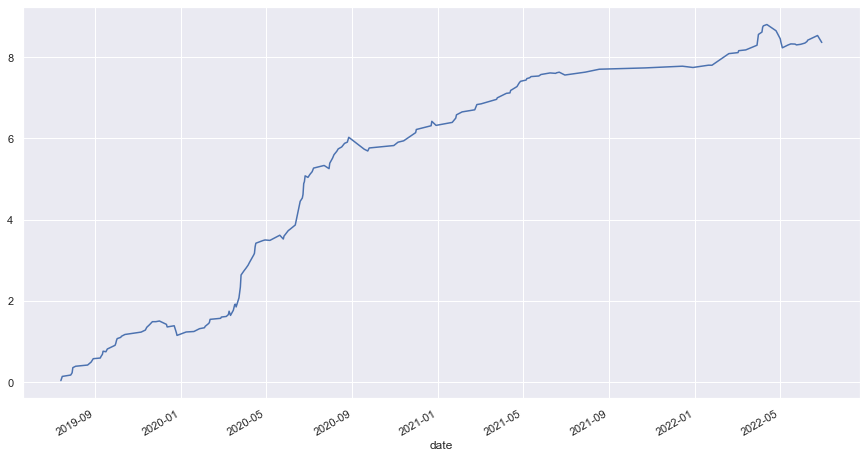

In [653]:
closed_daily.result.cumsum().plot()

In [600]:
closed.columns

Index(['date', 'pair', 'status', 'price_fst_stock', 'price_scnd_stock',
       'beta_open', 'beta_close', 'last_residual', 'std_residual',
       'std_open_residual', 'residual_open', 'open_price_first_stock',
       'open_price_scnd_stock', 'open_date', 'close_limit', 'stop_limit',
       'halflife', 'days_open', 'data_ini', 'data_fin', 'setor', 'sorted_pair',
       'result', 'result_beta_neutral', 'is_profit', 'is_profit_BN'],
      dtype='object')

In [601]:
closed[['price_fst_stock','price_scnd_stock', 'open_price_first_stock', 'open_price_scnd_stock','result']]

,price_fst_stock,price_scnd_stock,open_price_first_stock,open_price_scnd_stock,result
7,49.36,38.30,44.16,35.57,0.037374
106,57.80,36.92,53.12,39.64,-0.155521
190,38.14,25.71,38.16,23.78,0.078559
214,16.79,24.16,17.17,22.95,0.073761
258,26.84,17.10,22.97,12.49,-0.158446
...,...,...,...,...,...
12473,25.07,2.91,28.02,3.13,0.038367
12511,9.93,19.14,11.79,20.94,-0.081810
12531,2.86,12.47,4.26,17.05,-0.085623
12573,3.04,24.31,4.26,29.21,-0.153788


In [602]:
closed.groupby('sorted_pair').result.agg(['sum', 'count']).sort_values(by='sum', ascending=False).sum()

sum        2.906219
count    280.000000
dtype: float64

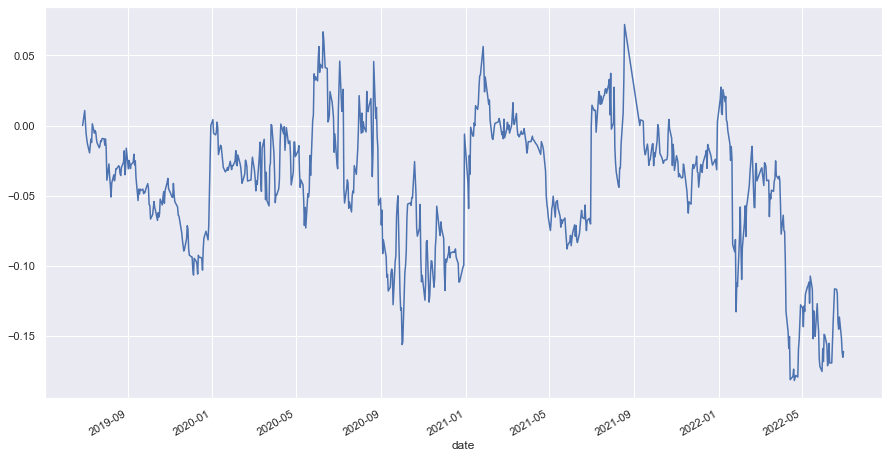

In [638]:
df.groupby('date').result.mean().plot()

In [637]:
cumsum_result.iloc[-1]

8.363897135984756

In [635]:
# cumsum_ibov = np.cumsum(np.log(ibov/ibov.shift()))
cumsum_result = np.cumsum(closed.groupby('date').result.mean())
cumsum_result_BN = np.cumsum(closed.groupby('date').result_beta_neutral.mean())

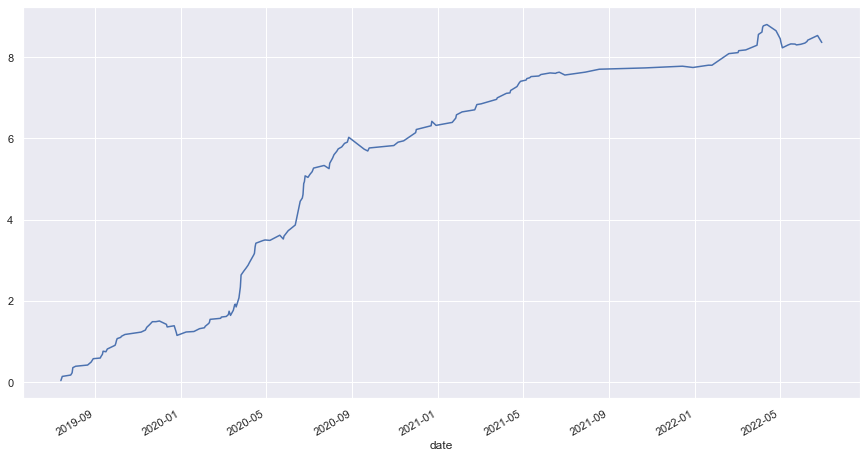

In [636]:
cumsum_result.plot()

In [629]:
vol = (df.groupby('date').result.mean().std()* math.sqrt(252) * 100)
vol

75.85744628035002

In [630]:
cumsum_result.iloc[-1]*100

290.62185113333584

In [631]:
#sharpe
(cumsum_result.iloc[-1]*100 )/ (closed.groupby('date').result.mean().std()* math.sqrt(252) * 100)

2.1858832029012256

In [632]:
closed.groupby('date').result.mean().std()* math.sqrt(252) * 100

132.95397061819514

In [633]:
(cumsum_result_BN.iloc[-1]*100 )/ (closed.groupby('date').result_beta_neutral.mean().std()* math.sqrt(252) * 100)

3.4733416526926937

In [375]:
sns.lineplot(x=cumsum_ibov.index, y=cumsum_ibov.close, label='ibov')
sns.lineplot(x=cumsum_result.index, y=cumsum_result, label='cointegration')
sns.lineplot(x=cumsum_result_BN.index, y=cumsum_result_BN, label='cointegration beta neutral')


NameError: name 'cumsum_ibov' is not defined

In [ ]:
ibov.loc['2020'].pct_change().std()[0]* math.sqrt(252) * 100